In [7]:
# Import the pandas package, then use the "read_csv" function to read
# the labeled training data

import pandas as pd
import re
from bs4 import BeautifulSoup

train = pd.read_csv("labeledTrainData.tsv", header = 0, delimiter = "\t", quoting = 3)

In [7]:
#Python Natural Language Toolkit for stop words, etc.
import nltk
#nltk.download()  # Download text data sets, including stop words

In [8]:
from nltk.corpus import stopwords # Import the stop word list
#print (stopwords.words("english")) 

In [10]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                 
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [11]:
clean_review = review_to_words( train["review"][0] )
print (clean_review)

In [13]:
#print(clean_train_reviews[:1])
print(len(clean_train_reviews))

25000


### Q1. Creating Design Matrices 

In [14]:
print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
#train_data_features = train_data_features.toarray()

X_counts = train_data_features.toarray()

Creating the bag of words...



#### X_counts created

In [15]:
########## X_counts created ##########
print (X_counts.shape)
print(max(X_counts[3]))

(25000, 5000)
4


#### Creating X_binary

In [16]:
######### Creating X_binary #########

import numpy as np

X_binary = np.zeros(shape=(25000,5000))

for i in range(0,24999):
    for j in range(0,4999):
        if (X_counts[i][j] > 0):
            X_binary[i][j] = 1
            
            

In [17]:
print (X_binary.shape)
print(max(X_binary[10]))

(25000, 5000)
1.0


#### Creating X_tfidf

In [18]:
############ Creating X_tfidf ##############
import sklearn
from sklearn.feature_extraction.text import TfidfTransformer

In [19]:
tfidf_transformer = TfidfTransformer(smooth_idf=False)
X_tfidf = tfidf_transformer.fit_transform(X_counts)

#### Creating X_imbalance

In [20]:
############## Creating X_imbalance ############
import random
random.seed(0)


indSent1 = train[train['sentiment'] == 1].index.values.tolist()
#print(len(indSent1))
indDel = np.random.choice(indSent1, 9375, replace = False)


print(len(indDel))

X_binary_imbalance = np.delete(X_binary, indDel, axis = 0)

print(X_binary_imbalance.shape)
print(X_binary.shape)




9375
(15625, 5000)
(25000, 5000)


In [21]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print (vocab[3])

ability


In [22]:
import numpy as np

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print (count, tag)

[[187 125 108 ..., 740 518 147]] abandoned


### Q2. Feature Space Similarity Experiment

In [23]:

import math



def dist(X, i, j, distance_function = 'Euclidean'):
    
    if (distance_function == 'Euclidean'):
        if((i <= len(X)-1) & (i >= 0) & (j <= len (X)-1) & (j >= 0)):
            sSq = 0
            for k in range(0,len(X[0]-1)) :
                sSq = sSq + (X[i][k] - X[j][k])**2
            return math.sqrt(sSq)
        else:
            print('For the matrix entered, row indices must be between 0 and', len(X)-1, "both inclusive")
            return
        
    else:
        print('distance_function must be "Euclidean"')
        return
    
print(dist(a, 0, 1, 'Euclidean'))



3.0


In [24]:
from sklearn.metrics.pairwise import euclidean_distances

from scipy.spatial.distance import pdist

#pdist(a, metric = 'euclidean')[0]

3.0

###### Because of system's computational limitations, creating Euclidean distance matrix in three parts 
###### by dividing the design matrix into two - row-wise parts
###### Then computing Euclidean distances between rows within each of the matrices, and between two matrices
###### Note: In Euclidean distance matrices, upper and lower triangular values are identical, so we can save computation

In [30]:


def topk(X, k):
    
    topkMatr = np.full((k,3),100)
    
    halfRow = int(len(X)/2)
    
    
    testMatr0 = euclidean_distances(X[:halfRow,:])
    
    testMatr1 = euclidean_distances(X[:halfRow,:], X[halfRow+1:,:])
    
    testMatr2 = euclidean_distances(X[halfRow+1:,:])
 

    for i in range(0,len(testMatr0[0])-1):
        for j in range(i+1, len(testMatr0[0])-1):
            for l in range(0, k-1):
                if (testMatr0[i][j] < topkMatr[l][2]):
                    topkMatr[l][2] = testMatr0[i][j]
                    topkMatr[l][0] = i
                    topkMatr[l][1] = j
                    break
    
    for i in range(0,len(testMatr1[0])-1):
        for j in range(0, len(testMatr1[0])-1):
            for l in range(0, k-1):
                if (testMatr1[i][j] < topkMatr[l][2]):
                    topkMatr[l][2] = testMatr1[i][j]
                    topkMatr[l][0] = i
                    topkMatr[l][1] = j
                    break
                
    for i in range(0,len(testMatr2[0])-1):
        for j in range(i+1, len(testMatr2[0])-1):
            for l in range(0, k-1):
                if (testMatr1[i][j] < topkMatr[l][2]):
                    topkMatr[l][2] = testMatr2[i][j]
                    topkMatr[l][0] = i
                    topkMatr[l][1] = j
                    break       
    
    
    return distMatr
            

#### The closest pairs in terms of Euclidean distances are the same in X_counts, X_binary

In [29]:
topkMatr = np.array([[    37.,   5536.,      0.],
       [   326.,   7336.,      0.],
       [   531.,   9467.,      0.],
       [   612.,  10730.,      0.],
       [   727.,  10513.,      0.],
       [  1053.,   1416.,      0.],
       [  1083.,   3461.,      0.],
       [  1290.,   1355.,      0.],
       [  1461.,   6013.,      0.],
       [  1614.,   3845.,      0.],
       [  1971.,  10091.,      0.],
       [  2018.,   6396.,      0.],
       [  2080.,   7584.,      0.],
       [  2159.,   5283.,      0.],
       [  2685.,  11597.,      0.],
       [  2804.,   4762.,      0.],
       [  2968.,  10186.,      0.],
       [  3092.,  11620.,      0.],
       [  3140.,   5970.,      0.],
       [  3264.,   9390.,      0.],
       [  3924.,   5796.,      0.],
       [  3949.,   5463.,      0.],
       [  4543.,  12168.,      0.],
       [  4723.,   9740.,      0.],
       [  4937.,   7794.,      0.],
       [  4975.,   6903.,      0.],
       [  4975.,   7610.,      0.],
       [  5065.,   6691.,      0.],
       [  5078.,  11344.,      0.],
       [   100.,    100.,    100.]])

##### Constructing the output required in Q2: indices of reviews, euclidean distance, first 40 characters, labels

In [81]:

cols = ['Index_1', 'Index_2', 'Euclidean_distance', 'Review_1', 'Review_2', 'Label_1', 'Label_2']
rows = []
for i in range(0,30): 
    rows.append(i)
print(cols, rows)

import pandas as pd

q2OP = pd.DataFrame(index = rows, columns = cols)
#print(q2OP["Index_1"][100])

for i in rows:
    Index_1 = int(topkMatr[i][0])
    Index_2 = int(topkMatr[i][1])
    q2OP["Index_1"][i] = Index_1
    q2OP["Index_2"][i] = topkMatr[i][1]
    q2OP["Euclidean_distance"][i] = topkMatr[i][2]
    q2OP["Review_1"][i] = str(train["review"][Index_1:Index_1+1])[6:25]
    q2OP["Review_2"][i] = str(train["review"][Index_2:Index_2+1])[6:25]
    q2OP["Label_1"][i] = int(train["sentiment"][Index_1:Index_1+1])
    q2OP["Label_2"][i] = int(train["sentiment"][Index_2:Index_2+1])


print(q2OP)

['Index_1', 'Index_2', 'Euclidean_distance', 'Review_1', 'Review_2', 'Label_1', 'Label_2'] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
   Index_1 Index_2 Euclidean_distance             Review_1  \
0       37    5536                  0  "Dumb is as dumb do   
1      326    7336                  0   "This guy has no i   
2      531    9467                  0   "Wow! So much fun!   
3      612   10730                  0   "There is no reaso   
4      727   10513                  0   "This movie surpri   
5     1053    1416                  0    "Awful, simply aw   
6     1083    3461                  0    "Everyone knows a   
7     1290    1355                  0    "I am not so much   
8     1461    6013                  0    "I really enjoyed   
9     1614    3845                  0    "The '60s is an o   
10    1971   10091                  0    "THE JIST: See so   
11    2018    6396                  0    "I find it ra

In [33]:
testMatr1 = euclidean_distances(X_binary[:12500,:], X_binary[12501:,:])

In [99]:
#testMatr0 = euclidean_distances(X_binary[:12500,:])

testCount = 0
for i in range(0,12499):
    for j in range(0,12499):
        if (testMatr0[i][j] != testMatr0[j][i]):
            testCount = testCount + 1
        
print(testCount)        

0


In [40]:
testMatr2 = euclidean_distances(X_binary[12501:,:])

In [50]:
testMatr0[0][:100]

array([  0.        ,  13.52774926,  16.24807681,  14.76482306,
        16.30950643,  12.60952021,  13.22875656,  13.26649916,
        14.07124728,  12.64911064,  12.72792206,  13.52774926,
        15.58845727,  13.22875656,  13.07669683,  14.24780685,
        15.39480432,  15.62049935,  14.17744688,  12.9614814 ,
        14.69693846,  14.83239697,  14.96662955,  12.60952021,
        12.52996409,  13.60147051,  13.92838828,  14.62873884,
        18.08314132,  13.11487705,  12.60952021,  13.49073756,
        13.56465997,  15.23154621,  14.59451952,  14.89966443,
        13.41640786,  13.3041347 ,  14.17744688,  16.76305461,
        14.52583905,  13.        ,  13.56465997,  13.26649916,
        13.67479433,  13.3041347 ,  12.80624847,  13.11487705,
        14.28285686,  13.41640786,  13.89244399,  13.26649916,
        13.85640646,  13.60147051,  12.489996  ,  13.60147051,
        13.82027496,  14.2126704 ,  12.68857754,  15.45962483,
        16.61324773,  14.62873884,  13.49073756,  13.56

In [102]:
print(topkMatr)

[[    37.   5536.      0.]
 [   326.   7336.      0.]
 [   531.   9467.      0.]
 [   612.  10730.      0.]
 [   727.  10513.      0.]
 [  1053.   1416.      0.]
 [  1083.   3461.      0.]
 [  1290.   1355.      0.]
 [  1461.   6013.      0.]
 [   100.    100.    100.]]


#### Q3. Classification Experiment 

In [4]:
################ Estimating the optimal C - repeating experiment 30 times 
################ using random sample of training set, because of computational limitations
import datetime
print(datetime.datetime.now().time())

import numpy as np
##################################

#Create the target np array - sentiment label

tgtSent = np.array(train["sentiment"], dtype=pd.Series)

randSampInd = random.sample(range(0,25000),1000)

print(len(tgtSent[randSampInd]))

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

########Because of system's computational limitations, using a random sample of 1000 records

X_train, X_test, y_train, y_test = train_test_split(X_binary.astype(int)[randSampInd][:], tgtSent.astype(int)[randSampInd], test_size=0.2, random_state=0)

scoresAggr = []
cAggr = []

for i in range(0,30):
    randomPower = random.randrange(-4, 4)
    cAggr.append(10**randomPower)
 
    


    
    clf = svm.SVC(kernel='linear', C=10**randomPower)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    
    scoresAggr.append(scores)






23:09:58.541611


NameError: name 'train' is not defined

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_binary.astype(int), tgtSent.astype(int), test_size=0.2, random_state=0)

clf_binary = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

y_score = clf_binary.fit(X_train, y_train).decision_function(X_test)

In [ ]:
################ Estimating the optimal C - repeating experiment 30 times ######################
################ using random sample of training set, because of computational limitations #############
import datetime
print(datetime.datetime.now().time())
##################################

#Create the target np array - sentiment label

tgtSent = np.array(train["sentiment"], dtype=pd.Series)

randSampInd = random.sample(range(0,25000),1000)

print(len(tgtSent[randSampInd]))

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

########Because of system's computational limitations, using a random sample of 1000 records

X_train, X_test, y_train, y_test = train_test_split(X_counts.astype(int)[randSampInd][:], tgtSent.astype(int)[randSampInd], test_size=0.2, random_state=0)

scoresAggr1 = []
cAggr1 = []

for i in range(0,30):
    randomPower = random.randrange(-4, 4)
    cAggr.append(10**randomPower)
 
    
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#print(clf.score(X_test, y_test))

    
    clf1 = svm.SVC(kernel='linear', C=10**randomPower)
    scores1 = cross_val_score(clf1, X_train, y_train, cv=5)
    
    scoresAggr1.append(scores1)



################Delete later

print(datetime.datetime.now().time())
##################################

X_train, X_test, y_train, y_test = train_test_split(X_binary.astype(int), tgtSent.astype(int), test_size=0.2, random_state=0)

clf_counts = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

y_score = clf_binary.fit(X_train, y_train).decision_function(X_test)


In [ ]:
########################### Plotting Receiver Operating Characteristic: X_binary #############################
# source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [130]:
from sklearn.preprocessing import label_binarize

bin_y = label_binarize(y_test, classes=[0, 1, 2])
n_classes = bin_y.shape[1]
print(len(y_score), len(y_test), len(y_train), len(X_train), len(X_test))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

5000 5000 20000 20000 5000


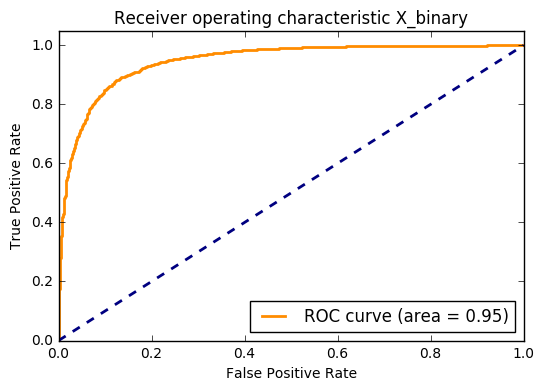

In [133]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic X_binary')
plt.legend(loc="lower right")
plt.show()

In [105]:
################## Create test matrices from testData.csv ############################
test = pd.read_csv("testData.tsv", header = 0, delimiter = "\t", quoting = 3)

# Get the number of reviews based on the dataframe column size
num_testreviews = test["review"].size

print ("Cleaning and parsing the test set movie reviews...\n")
clean_test_reviews = []
for i in range( 0, num_testreviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print ("Review %d of %d\n" % ( i+1, num_testreviews ) )                                                                   
    clean_test_reviews.append( review_to_words( test["review"][i] ))

Cleaning and parsing the test set movie reviews...

Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



In [1]:
print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
test_data_features = vectorizer.fit_transform(clean_test_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
#train_data_features = train_data_features.toarray()
X_testcounts = test_data_features.toarray()

Creating the bag of words...



NameError: name 'clean_test_reviews' is not defined

In [110]:
###Creating the X_testbinary matrix

import numpy as np

X_testbinary = np.zeros(shape=(25000,5000))

for i in range(0,24999):
    for j in range(0,4999):
        if (X_testcounts[i][j] > 0):
            X_testbinary[i][j] = 1
            

In [114]:
###Creating the X_testtfifd matrix

import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_testtransformer = TfidfTransformer(smooth_idf=False)
X_testtfidf = tfidf_testtransformer.fit_transform(X_testcounts)

In [134]:
################ predicting on the X_testbinary design matrix (Kaggle test set) ######################

y_test_predicted = clf_binary.predict(X_testbinary)



In [149]:
import csv
kaggle_submission = pd.DataFrame(
    {'id': test["id"].tolist(),
     'sentiment': y_test_predicted.tolist()
    })

kaggle_submission.to_csv('kaggle_submission.csv', index = False, quoting = csv.QUOTE_NONE)

In [ ]:
################## submission scored 0.57928 ###########################

In [ ]:
############################ Q4. Logistic Regression Learning Curve ##############################

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

tgtSent = np.array(train["sentiment"], dtype=pd.Series)
sampleSizes = [100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000]


listTrainingError = []

for sampleSize in sampleSizes:
    randomIndex = random.sample(range(0,25000), sampleSize)
    
    X_train, X_test, y_train, y_test = train_test_split(X_counts.astype(int)[randomIndex], tgtSent.astype(int)[randomIndex], test_size=0.2, random_state=0)
    model2 = LogisticRegression()
    model2.fit(X_train, y_train)
    predicted = model2.predict(X_test)
    listTrainingError.append(float('%.3f'%(1- (np.sum(y_test == predicted)/sampleSize))))

In [ ]:
print(listTrainingError)

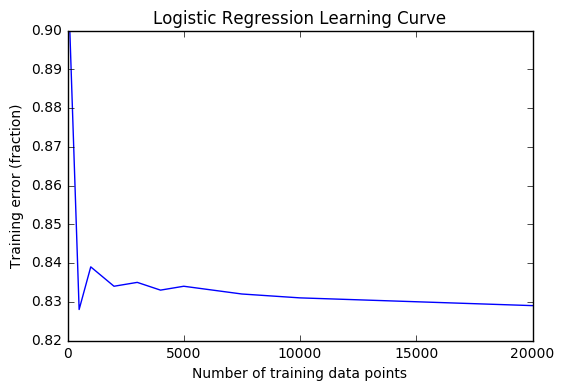

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
 
plt.figure()

plt.plot(sampleSizes, listTrainingError)

plt.xlabel("Number of training data points")
plt.ylabel("Training error (fraction)")
plt.title("Logistic Regression Learning Curve")


In [ ]:
Logistic Regression Learning Curve interpretation:
As the number of data points in the training set increases, the model's performance:
1. Improves
2. Stabilizes 
in terms of the training error